In [59]:
RANDOM_SEED = 42
SAMPLE_DATA_PERCENTAGE = 0.1
MIN_IOU_REQUIRED = 0.7  # The minimum IOU required to be a good detection (ie higher is more strict)
NUM_PROPOSALS = 300
CHECKPOINT_DIR = './idd_car_drop_checkpoints'

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch as t
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
import numpy as np
import pickle
import h5py
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
from utils.config import opt
from utils.idd_utils import get_annotations
from model.utils.bbox_tools import bbox_iou

from data.dataset import Dataset, TestDataset, KittiDataset
from torch.utils.data import DataLoader
from utils.vis_tool import vis_bbox, vis_image
from utils.idd_utils import IndiaDrivingDataset
from ood_metrics import auroc, plot_roc, calc_metrics
from sklearn import svm
import pickle
import itertools
import torch
from model.faster_rcnn import nograd
from data.dataset import preprocess
from utils.mahalanobis import Mahal_Dist


import warnings
warnings.filterwarnings(action='once')

np.random.seed(RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
idd_data_dir = "/media/tadenoud/DATADisk/datasets/idd_detection/IDD_Detection/"

kitti_train_dataset = KittiDataset(opt, split='train')
kitti_val_dataset = KittiDataset(opt, split='val')
idd_val_dataset = IndiaDrivingDataset(idd_data_dir, split='val')

kitti_train_samples = round(len(kitti_train_dataset) * SAMPLE_DATA_PERCENTAGE)
kitti_val_samples = round(len(kitti_val_dataset) * SAMPLE_DATA_PERCENTAGE)
idd_val_samples = round(len(idd_val_dataset) * SAMPLE_DATA_PERCENTAGE)

KITTI_TRAIN_TO_USE = np.random.choice(kitti_train_samples, kitti_train_samples, replace=False)
KITTI_VAL_TO_USE = np.random.choice(kitti_val_samples, kitti_val_samples, replace=False)
IDD_VAL_TO_USE = np.random.choice(idd_val_samples, idd_val_samples, replace=False)


# Datasets after sampling a portion of them
kitti_train_dataset = torch.utils.data.Subset(kitti_train_dataset, KITTI_TRAIN_TO_USE)
kitti_val_dataset = torch.utils.data.Subset(kitti_val_dataset, KITTI_VAL_TO_USE)
idd_val_dataset = torch.utils.data.Subset(idd_val_dataset, IDD_VAL_TO_USE)

In [61]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn, visdom=False).cuda()

# Load model trained with caffe pretrained model

In [62]:
%ls ./checkpoints/cars_drop/

fasterrcnn_11060017_0.7454640828611436  fasterrcnn_11061638_0.7497252402944325
fasterrcnn_11061427_0.7282598515502949  fasterrcnn_11061705_0.7526206908232453
fasterrcnn_11061454_0.733123502219126   fasterrcnn_11062316_0.7550167879591324
fasterrcnn_11061507_0.7394557961451338


In [63]:
save_dir = './checkpoints/cars_drop'
trainer.load(os.path.join(save_dir, 'fasterrcnn_11062316_0.7550167879591324'))
trainer.faster_rcnn.eval()

FasterRCNNVGG16(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

# Extract classifier features

In [64]:
string_dt = h5py.string_dtype(encoding='utf-8')
feature_layer_sizes = (512, 4096, 4096)

In [65]:
def extract_kitti_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                
                
def extract_idd_features(dataset, model, save_file, perturbation=0, temperature=1):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True, perturbation=perturbation, temperature=temperature)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_scores", data=pred_scores)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                d.create_dataset("pred_features_" + str(j), data=feats)
                

def show_max_ious_dist(data_file):
    """
    Given a data file generated by one of the feature_extractor functions, show the distribution 
    of IOUs with the gt data.
    """
    total_false_positives = 0
    all_max_ious = np.array([])

    with h5py.File(data_file, "r") as f:
        dset_length = len(f)
        for i in range(dset_length):
            max_ious = f[str(i)]["pred_max_ious"][()]

            false_positives = (max_ious < MIN_IOU_REQUIRED)
            total_false_positives += sum(false_positives)

            all_max_ious = np.concatenate((all_max_ious, max_ious), axis=0)

    plt.hist(all_max_ious, bins=50)
    plt.ylabel("Count")
    plt.xlabel("Max IOUS")
    plt.show()

    total_detections = len(all_max_ious)
    print("Total false positives (< %.2f) IoU: %d" % (MIN_IOU_REQUIRED, total_false_positives))
    print("Total detections: %d" % (total_detections))
    print("Total false positives (< %.2f) IoU: %f%%" % (MIN_IOU_REQUIRED, float(total_false_positives)/float(total_detections)))
    

def read_features(save_file, feature_idx):
    """
    Read the features from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_features_%d" % feature_idx][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y


def read_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]
            
            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=0)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return X, y

# Extract classifier features

#### Kitti Train

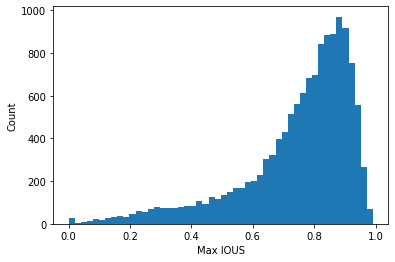

Total false positives (< 0.70) IoU: 3850
Total detections: 13355
Total false positives (< 0.70) IoU: 0.288282%


In [18]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")

if False:
    extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### Kitti Val

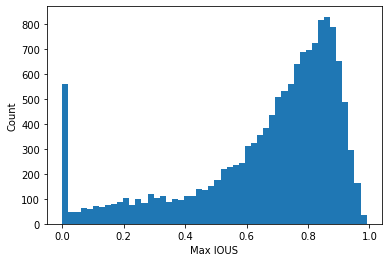

Total false positives (< 0.70) IoU: 5862
Total detections: 14115
Total false positives (< 0.70) IoU: 0.415303%


In [19]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")

if False:
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

#### IDD Val

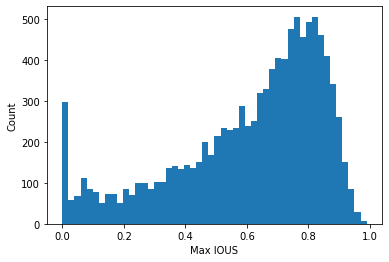

Total false positives (< 0.70) IoU: 5682
Total detections: 10506
Total false positives (< 0.70) IoU: 0.540834%


In [20]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")

if False:
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_path)

show_max_ious_dist(save_path)

## One-Class SVM on Kitti features (Conv-512 layer)

In [21]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 0)

In [22]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-conv-512-one-class.pickle")
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if False:
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])
    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 9494 train samples of size 512


#### Kitti Train

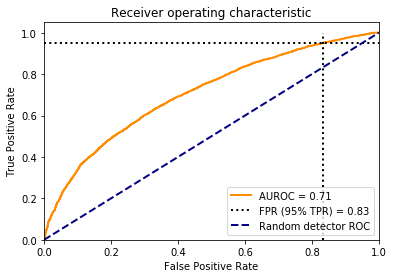

{'fpr_at_95_tpr': 0.8326858326858327, 'detection_error': 0.4411480564313933, 'auroc': 0.7064954722422596, 'aupr_in': 0.8485794743282613, 'aupr_out': 0.4816558943272705}


In [23]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [24]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 0)

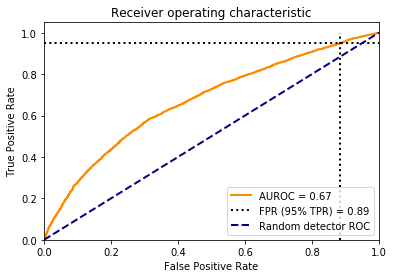

{'fpr_at_95_tpr': 0.8850438892640108, 'detection_error': 0.4674273285900081, 'auroc': 0.6695734481885101, 'aupr_in': 0.7287973072592653, 'aupr_out': 0.5620690039778127}


In [25]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [26]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 0)

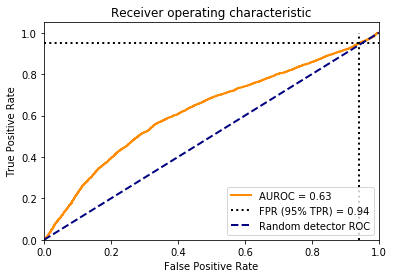

{'fpr_at_95_tpr': 0.9420763148848401, 'detection_error': 0.4959333500129644, 'auroc': 0.6263017151666536, 'aupr_in': 0.5645673448695621, 'aupr_out': 0.6296047188465176}


In [27]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

## One-Class SVM on Kitti features (FC-4096 (#1) layer) 

In [28]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 1)

In [29]:
# Train a one-class SVM networks with those features
ONE_CLASS_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "kitti-fc-4096-1-one-class.pickle")
    
training_mask = kitti_train_y.astype(np.bool)

print("Collected %d train samples of size %d" % kitti_train_X[training_mask].shape)

if True:
    clf = svm.OneClassSVM(nu=0.001, kernel="rbf")

    # Use only correct detections for training
    clf.fit(kitti_train_X[training_mask])

    y_pred_train = clf.predict(kitti_train_X[training_mask])

    n_error_train = y_pred_train[y_pred_train == -1].size
    print(n_error_train)
    
    with open(ONE_CLASS_SAVE_PATH, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(ONE_CLASS_SAVE_PATH, 'rb') as f:
        clf = pickle.load(f)

Collected 9494 train samples of size 4096


/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


8


#### Kitti Train

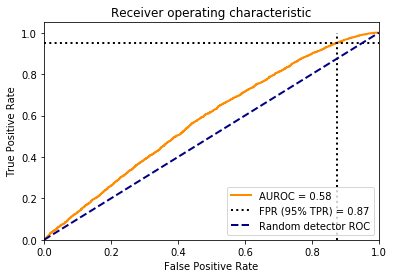

{'fpr_at_95_tpr': 0.8736078736078736, 'detection_error': 0.4617144065743181, 'auroc': 0.581378214198943, 'aupr_in': 0.7545029278078615, 'aupr_out': 0.39088635443131386}


In [30]:
kitti_train_novelty_scores = clf.decision_function(kitti_train_X)
plot_roc(kitti_train_novelty_scores, kitti_train_y)
print(calc_metrics(kitti_train_novelty_scores, kitti_train_y))

#### Kitti Val

In [31]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 1)

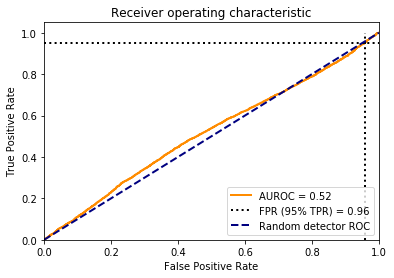

{'fpr_at_95_tpr': 0.9571235651586766, 'detection_error': 0.4984822915848334, 'auroc': 0.5176524525732735, 'aupr_in': 0.5977155173679154, 'aupr_out': 0.42413616469093834}


In [32]:
kitti_val_novelty_scores = clf.decision_function(kitti_val_X)
plot_roc(kitti_val_novelty_scores, kitti_val_y)
print(calc_metrics(kitti_val_novelty_scores, kitti_val_y))

#### IDD Val

In [33]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 1)

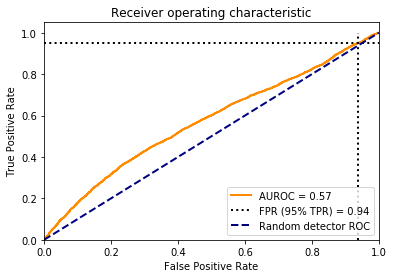

{'fpr_at_95_tpr': 0.9389824682021313, 'detection_error': 0.49442785688055313, 'auroc': 0.5726858185201393, 'aupr_in': 0.5212680595358746, 'aupr_out': 0.5977510368221697}


In [34]:
idd_val_novelty_scores = clf.decision_function(idd_val_X)
plot_roc(idd_val_novelty_scores, idd_val_y)
print(calc_metrics(idd_val_novelty_scores, idd_val_y))

# Max Softmax

#### Kitti train

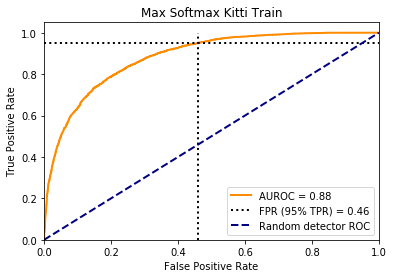

{'fpr_at_95_tpr': 0.45997472087634295, 'detection_error': 0.25498088543169645, 'auroc': 0.882062742553579, 'aupr_in': 0.7575723825304248, 'aupr_out': 0.9476160965843337}


In [35]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_scores(save_path)

kitti_train_novelty_scores = -kitti_train_X
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Max Softmax Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

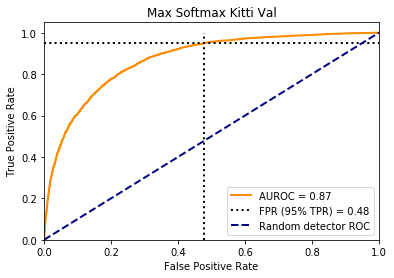

{'fpr_at_95_tpr': 0.47820778903674765, 'detection_error': 0.26408701403221585, 'auroc': 0.8704300478506448, 'aupr_in': 0.8216575251251392, 'aupr_out': 0.8987246967874841}


In [36]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_scores(save_path)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Max Softmax Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

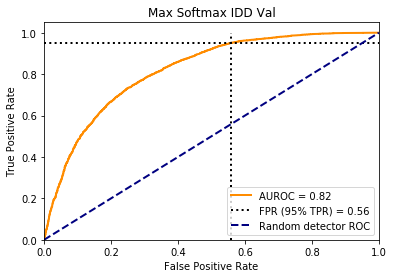

{'fpr_at_95_tpr': 0.5575938566552902, 'detection_error': 0.3036336419749466, 'auroc': 0.8191448372240088, 'aupr_in': 0.8222525729969069, 'aupr_out': 0.8054130353557665}


In [37]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_scores(save_path)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Max Softmax IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

# Mahalanobis

#### Kitti train

In [38]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train.hdf5")
kitti_train_X, kitti_train_y = read_features(save_path, 2)

In [39]:
mahal_model_name = os.path.join(CHECKPOINT_DIR, "kitti-cars-fc-4096-2-mahalanobis.h5")

if False:
    kitti_mahalanobis_features = kitti_train_X[kitti_train_y.astype(np.bool)]
    kitti_mahalanobis_labels = np.zeros((len(kitti_mahalanobis_features)))
    
    md = Mahal_Dist(kitti_mahalanobis_features, kitti_mahalanobis_labels)
    
    md.save(mahal_model_name)
    
else:
    md = Mahal_Dist.load(mahal_model_name)

Calculating mahal mean
Calculating mahal cov
Inverting


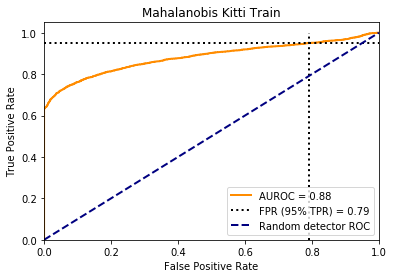

{'fpr_at_95_tpr': 0.7927111860122182, 'detection_error': 0.4213491179996341, 'auroc': 0.8818234523943392, 'aupr_in': 0.8624483236210849, 'aupr_out': 0.914103517020318}


In [40]:
kitti_train_novelty_scores = md(kitti_train_X)
plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="Mahalanobis Kitti Train")
print(calc_metrics(kitti_train_novelty_scores, 1 - kitti_train_y))

#### Kitti val

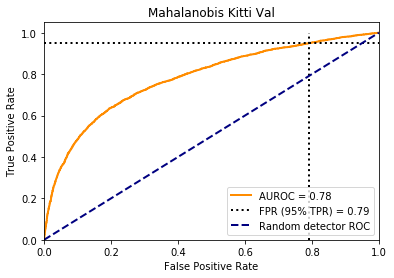

{'fpr_at_95_tpr': 0.7925772188987914, 'detection_error': 0.4212717289632377, 'auroc': 0.7807164567985266, 'aupr_in': 0.734374034486831, 'aupr_out': 0.7998471884929493}


In [41]:
save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val.hdf5")
kitti_val_X, kitti_val_y = read_features(save_path, 2)

kitti_val_novelty_scores = md(kitti_val_X)
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="Mahalanobis Kitti Val")
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

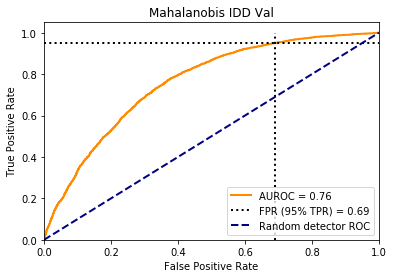

{'fpr_at_95_tpr': 0.6887798634812287, 'detection_error': 0.3691614203067566, 'auroc': 0.7593751429892167, 'aupr_in': 0.7656164083295478, 'aupr_out': 0.725297926864644}


In [42]:
save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val.hdf5")
idd_val_X, idd_val_y = read_features(save_path, 2)

idd_val_novelty_scores = md(idd_val_X)
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="Mahalanobis IDD Val")
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

# Extended Feature Extractor Set

### Bind a feature extractor function to the model

In [43]:
model = trainer.faster_rcnn

@nograd
def get_all_features(self, imgs, visualize=False):
    self.eval()
    if visualize:
        prepared_imgs = list()
        for img in imgs:
            img = preprocess(at.tonumpy(img))
            prepared_imgs.append(img)
    else:
         prepared_imgs = imgs 

    for img in prepared_imgs:
        img = at.totensor(img[None], cuda=True).float()
        features = [img]
        
        for l in self.extractor:
            features.append(l(features[-1]))
        
        # Detach all features from GPU
        features = [at.tonumpy(f) for f in features]
        # Remove the first feature (ie the image)
        features = features[1:]
        # Average the features over the final two dimensions
        features = [np.mean(f, axis=(2,3)).squeeze(axis=0) for f in features]
        return features
    
model.get_all_features = get_all_features.__get__(model)

### Get the GT features

In [44]:
def extract_extended_kitti_features_gt(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            cars_bboxes = gt_bboxes[gt_labels == 0]
            
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(cars_bboxes):
                d_car = d.create_group("gt_bbox_"+str(j))
                y1, x1, y2, x2 = box.type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]
                
                # Check correct sections of image are extracted
                # plt.imshow(np.moveaxis(np.squeeze(at.tonumpy(im), axis=0), 0, 2).astype(np.int))
                # plt.show()
                
                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_car.create_dataset("extended_feat_"+str(k), data=feats)

if False:
    dataset = KittiDataset(opt, split='train')
    extract_extended_kitti_features_gt(dataset, trainer.faster_rcnn, "kitti_cars_detections_train_extended_gt.hdf5")

In [ ]:
def extract_extended_kitti_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            sizes = [sizes[0][0].item(), sizes[1][0].item()]
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)
            
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))

            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
                    
def extract_extended_idd_features(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))
            
            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict_with_features(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores, pred_features = res
            pred_bboxes, pred_labels, pred_scores, pred_features = \
                    pred_bboxes[0], pred_labels[0], pred_scores[0], pred_features[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels

            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            preds = d.create_group('pred')
            preds.create_dataset("pred_boxes", data=pred_bboxes)
            preds.create_dataset("pred_scores", data=pred_scores)
            preds.create_dataset("pred_labels", data=pred_labels)
            preds.create_dataset("pred_num_detections", data=len(pred_bboxes))
            preds.create_dataset("pred_max_ious", data=max_ious) 
            preds.create_dataset("pred_label_correct", data=pred_label_correct) 

            for j, feats in enumerate(pred_features):
                preds.create_dataset("pred_features_" + str(j), data=feats)
                
            bboxes = d.create_group('bboxes')
            # Get the extended feature set from the cropped bbox sections
            # Crop each image to the gt_bboxes and get features
            for j, box in enumerate(at.totensor(pred_bboxes)):
                d_box = bboxes.create_group(str(j))
                y1, x1, y2, x2 = box.round().type(torch.int)
                im = imgs[:,:,y1:y2,x1:x2]

                # Get predictions and all classifier features
                features = model.get_all_features(im, visualize=True)
                for k, feats in enumerate(features):
                    d_box.create_dataset("extended_feat_"+str(k), data=feats)
                    
if False:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
    extract_extended_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_path)

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
    extract_extended_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_path)

if True:
    save_path = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
    extract_extended_idd_features(idd_val_dataset, trainer.faster_rcnn, )

## ODIN

In [46]:
# TODO: DO THIS PROPER!!!!!
# in this dir: CHECKPOINT_DIR = './idd_car_drop_checkpoints'
CHECKPOINT_DIR = './idd_car_checkpoints'

In [47]:
# for T 1, 2, 5, 10,20, 50, 100, 200, 500, 1000; and for perturbation magnitude
# ε we choose from 21 evenly spaced numbers starting from 0
# and ending at 0.004.
# temperatures = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
temperatures = np.array([1000])
epsilons = np.linspace(0, 0.004, 21)
# epsilons = np.linspace(0, 0.004, 10)
# epsilons = np.array([0.001])


odin_params = list(itertools.product(epsilons, temperatures))

# PERTURBATION = 0
# TEMP = 2

#### Kitti train

In [48]:
# for eps, temp in odin_params:

#     save_file = "kitti_cars_detections_train_pert_%f_temp_%d.hdf5" % (eps, temp)

#     if True:
#         extract_kitti_features(kitti_train_dataset, trainer.faster_rcnn, save_file, eps, temp)
#     show_max_ious_dist(save_file)

#     kitti_train_X, kitti_train_y = read_scores(save_file)

#     kitti_train_novelty_scores = -kitti_train_X
#     plot_roc(kitti_train_novelty_scores, 1 - kitti_train_y, title="ODIN Kitti Train e=%f, T=%d" %(eps, temp))

#### Kitti val

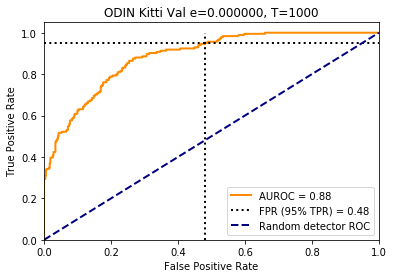

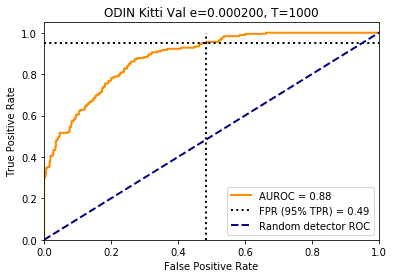

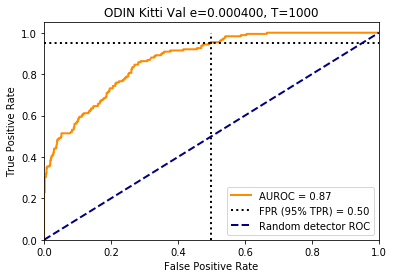

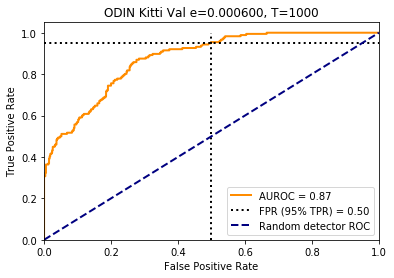

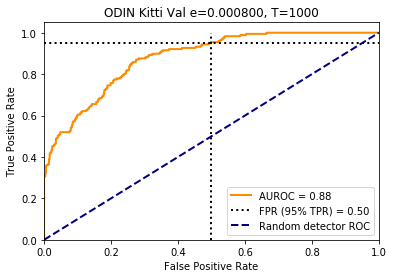

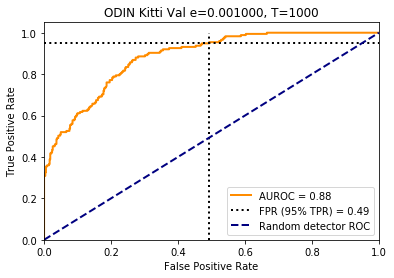

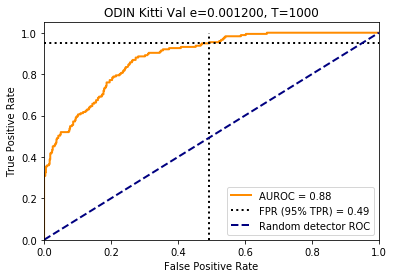

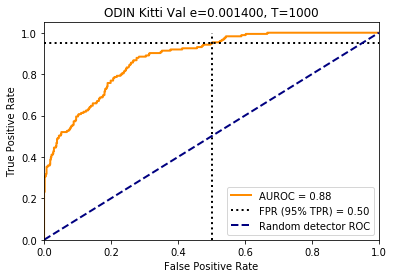

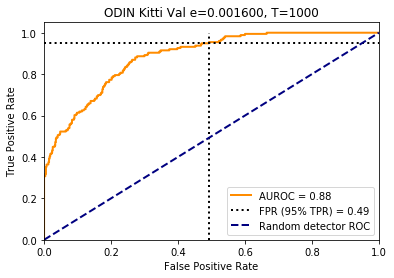

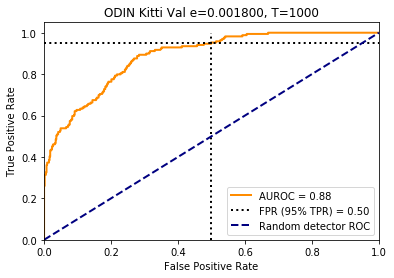

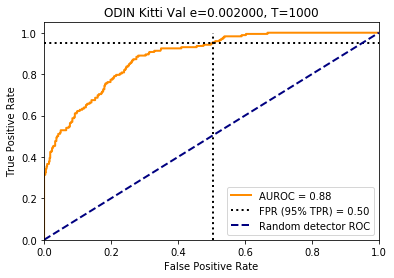

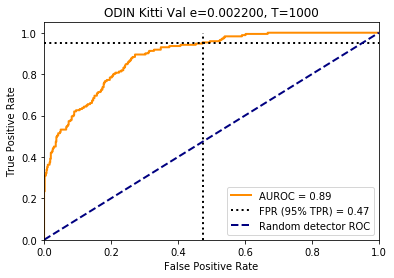

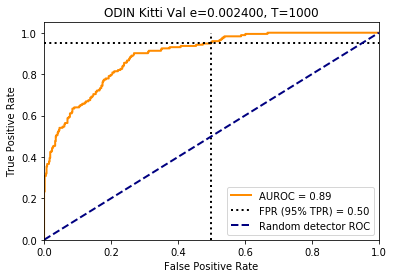

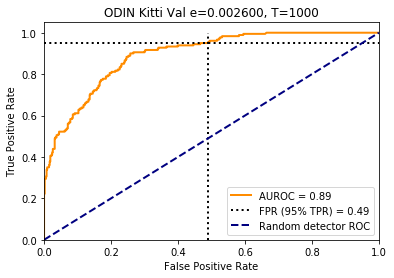

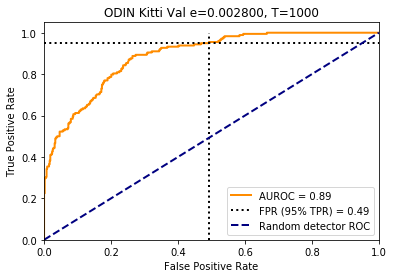

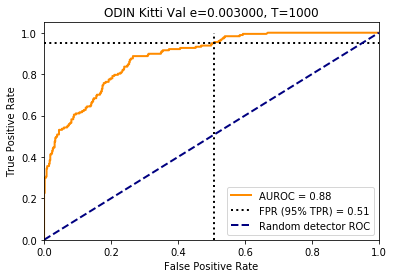

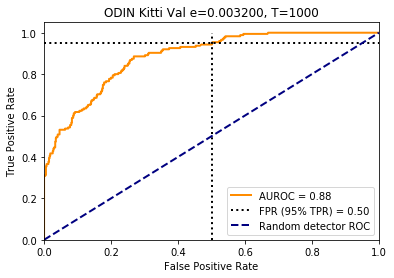

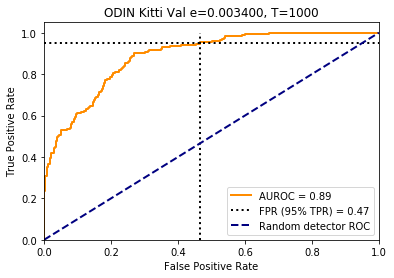

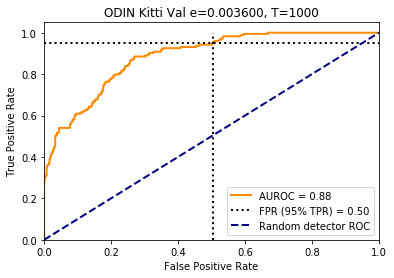

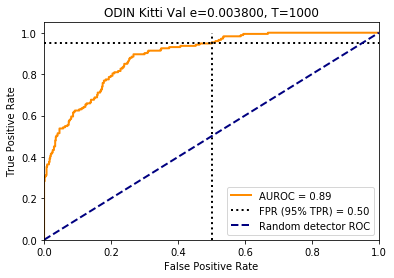

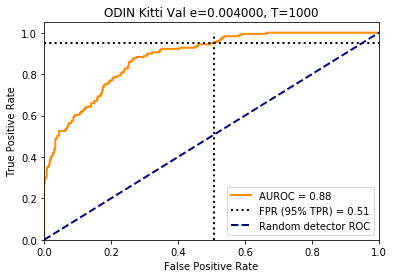

In [49]:
for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    if False:# and not os.path.exists(save_file):
        extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)
    
#     show_max_ious_dist(save_file)

    kitti_val_X, kitti_val_y = read_scores(save_file)
    
    kitti_val_novelty_scores = -kitti_val_X
    plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="ODIN Kitti Val e=%f, T=%d" %(eps, temp))

In [50]:
results = []

for eps, temp in tqdm(odin_params, total=len(odin_params)):
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

    kitti_val_X, kitti_val_y = read_scores(save_file)
    kitti_val_novelty_scores = -kitti_val_X
    
    results.append(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

Best params: (0.0034000000000000002, 1000)


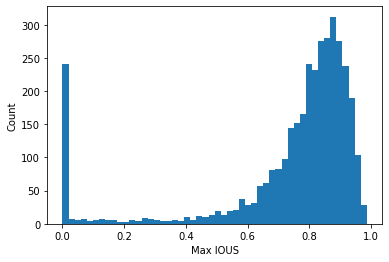

Total false positives (< 0.70) IoU: 802
Total detections: 3578
Total false positives (< 0.70) IoU: 0.224148%


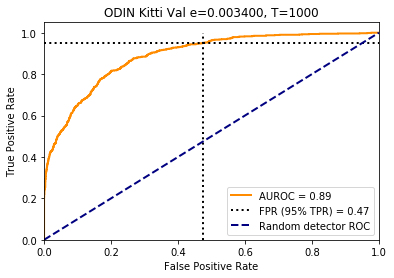

{'fpr_at_95_tpr': 0.47368421052631576, 'detection_error': 0.2617177271537051, 'auroc': 0.8888748399315607, 'aupr_in': 0.7535485321928448, 'aupr_out': 0.9607744223598884}


In [51]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results])
print("Best params:", odin_params[best_params])

eps, temp = odin_params[best_params]
save_file = os.path.join(CHECKPOINT_DIR, "all_data_kitti_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False and not os.path.exists(save_file):
    extract_kitti_features(kitti_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

show_max_ious_dist(save_file)

kitti_val_X, kitti_val_y = read_scores(save_file)

kitti_val_novelty_scores = -kitti_val_X
plot_roc(kitti_val_novelty_scores, 1 - kitti_val_y, title="ODIN Kitti Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(kitti_val_novelty_scores, 1 - kitti_val_y))

#### IDD val

Best params: (0.0034000000000000002, 1000)


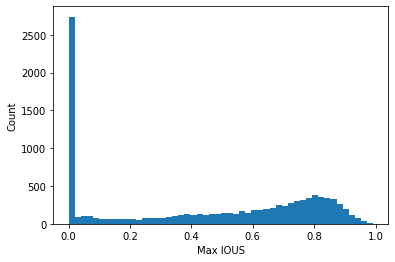

Total false positives (< 0.70) IoU: 6726
Total detections: 10225
Total false positives (< 0.70) IoU: 0.657800%


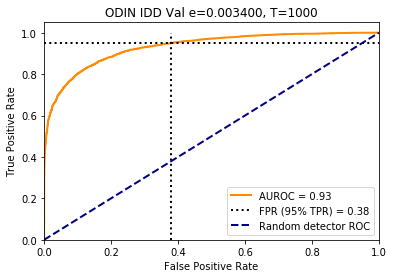

{'fpr_at_95_tpr': 0.3802773497688752, 'detection_error': 0.21498459167950695, 'auroc': 0.9307232197650342, 'aupr_in': 0.9680747368572209, 'aupr_out': 0.8562060941168608}


In [52]:
best_params = np.argmin([x['fpr_at_95_tpr'] for x in results])
print("Best params:", odin_params[best_params])

eps, temp = odin_params[best_params]
save_file = os.path.join(CHECKPOINT_DIR, "all_data_idd_cars_detections_val_pert_%f_temp_%d.hdf5" % (eps, temp))

if False and not os.path.exists(save_file):
    extract_idd_features(idd_val_dataset, trainer.faster_rcnn, save_file, eps, temp)

show_max_ious_dist(save_file)

idd_val_X, idd_val_y = read_scores(save_file)

idd_val_novelty_scores = -idd_val_X
plot_roc(idd_val_novelty_scores, 1 - idd_val_y, title="ODIN IDD Val e=%f, T=%d" %(eps, temp))
print(calc_metrics(idd_val_novelty_scores, 1 - idd_val_y))

## Train multiple SVM classifiers

In [53]:
# Train a one-class SVM networks with those features
GT_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended_gt.hdf5")
KITTI_TRAIN_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_train_extended.hdf5")
KITTI_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_extended.hdf5")
IDD_VAL_FEATURES_FILE = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_extended.hdf5")
NUM_EXTENDED_FEATURES = 30

def read_gt_extended_features(file, feature_idx):
    features = None
    
    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            for gt_bbox in im.keys():
                gt_bbox = im[gt_bbox]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features


def read_extended_features(file, feature_idx):
    features = None
    labels = np.empty((0,))

    with h5py.File(file, "r") as f:
        for im in tqdm(f.keys(), total=len(f), leave=False):
            im = f[im]
            
            # Get the correctness labels
            label_is_car = im['pred']["pred_labels"][()] == 0
            iou_is_high_enough = im['pred']["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = im['pred']["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            labs = 1 - (label_is_car & iou_is_high_enough & classification_is_correct)
            labels = np.concatenate((labels, labs), axis=0)

            # Get the required features
            for j in im['bboxes'].keys():
                gt_bbox = im['bboxes'][j]
                feats = gt_bbox["extended_feat_%d" % feature_idx]

                if features is None:
                    features = np.expand_dims(feats, axis=0)
                else:
                    features = np.concatenate((features, np.expand_dims(feats, axis=0)), axis=0)
    
    return features, labels

# Train all the classifiers
def train_osvm(nu, gamma, kernel, train_features, one_class_save_path):
        # Train one class SVM
        clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        clf.fit(train_features)

        # Save classifier
        with open(one_class_save_path, 'wb') as f:
            pickle.dump(clf, f)

NUS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# GAMMAS = ['auto', 'scale']
GAMMAS = ['auto']
# KERNELS = ['rbf', 'linear']
KERNELS = ['rbf']

train_args = list(itertools.product(NUS, GAMMAS, KERNELS))

if False:
    for i in trange(NUM_EXTENDED_FEATURES):
        features_gt = read_gt_extended_features(GT_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            train_osvm(nu, gamma, kernel, features_gt, save_path)

In [54]:
if False:
    kitti_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):

        # Load the kitti val features
        kitti_val_X, kitti_val_y = read_extended_features(KITTI_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            kitti_val_novelty_scores = -clf.decision_function(kitti_val_X)
            res = calc_metrics(kitti_val_novelty_scores, kitti_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            kitti_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/kitti_val_results.pickle'), 'wb') as f:
        pickle.dump(kitti_val_results, f)

else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/kitti_val_results.pickle'), 'rb') as f:
        kitti_val_results = pickle.load(f)

In [55]:
if False:
    idd_val_results = []

    for i in trange(NUM_EXTENDED_FEATURES):
        # Load the idd_val features
        idd_val_X, idd_val_y = read_extended_features(IDD_VAL_FEATURES_FILE, i)

        for nu, gamma, kernel in tqdm(train_args, total=len(train_args), leave=False):
            # Load the classifier
            save_path = os.path.join(CHECKPOINT_DIR, "one_class_models/kitti-one-class-extended-feat%d-nu%.4f-gamma%s-kernel%s.pickle" % (i, nu, gamma, kernel))
            with open(save_path, 'rb') as f:
                clf = pickle.load(f)

            # Calculate performance metrics
            idd_val_novelty_scores = -clf.decision_function(idd_val_X)
            res = calc_metrics(idd_val_novelty_scores, idd_val_y.astype(np.int))

            res['nu'] = nu
            res['gamma'] = gamma
            res['kernel'] = kernel
            res['features'] = i
            res['model'] = save_path

            idd_val_results.append(res)

    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/idd_val_results.pickle'), 'wb') as f:
        pickle.dump(idd_val_results, f)
    
else:
    with open(os.path.join(CHECKPOINT_DIR, 'one_class_models/idd_val_results.pickle'), 'rb') as f:
        idd_val_results = pickle.load(f)

In [56]:
best_params = np.argmin([k['detection_error'] for k in kitti_val_results])
# best_params = np.argmax([k['aupr_in'] for k in kitti_val_results])

print(best_params)
print(kitti_val_results[best_params])

398
{'fpr_at_95_tpr': 0.8052057094878253, 'detection_error': 0.4273707166295448, 'auroc': 0.623516406383837, 'aupr_in': 0.2868063872483848, 'aupr_out': 0.8672238905326176, 'nu': 0.003, 'gamma': 'scale', 'kernel': 'rbf', 'features': 12, 'model': 'one_class_models/kitti-one-class-extended-feat12-nu0.0030-gammascale-kernelrbf.pickle'}


In [57]:
# best_params = np.argmin([k['fpr_at_95_tpr'] for k in idd_val_results])
# best_params = np.argmax([k['aupr_in'] for k in idd_val_results])

print(idd_val_results[best_params])

{'fpr_at_95_tpr': 0.9764804703905922, 'detection_error': 0.4993066873775461, 'auroc': 0.4567377235617505, 'aupr_in': 0.3290476906396844, 'aupr_out': 0.633263818216179, 'nu': 0.003, 'gamma': 'scale', 'kernel': 'rbf', 'features': 12, 'model': 'one_class_models/kitti-one-class-extended-feat12-nu0.0030-gammascale-kernelrbf.pickle'}


### TODO:

- ~~Make a Pytorch dataset class for IDD~~
- ~~Train SVM models with extracted features~~
- ~~Improve data structure for saving features~~
    - ~~Less space requirement via hdf5 dataset per image~~

- ~~Resolve bi-modal kitti max IOU (bug? wrong loader? BG class?)~~
- ~~(Nov 23) Results for max softmax~~
- ~~(Nov 23) Results for Mahalanobis~~
- ~~(Nov 25) Results for an extended feature set classifier~~
- ~~(Nov 26) Test various SVM parameters to maximize performance (See Vahdat's paper)~~
- ~~ODIN~~
- Mahalanobis with input perturbation
- ~~Cars model (Use dropout)~~
- Entropy / Mutual Information

Ideas: 
    
    - Get rid of ignore index in crossentropy function in perturbation function
    -Increase the minimum IOU to be considered a good prediction

## Entropy

In [58]:
CHECKPOINT_DIR = './idd_car_drop_checkpoints'

In [ ]:
NUM_MC_PASSES = 10

def extract_kitti_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    model.train()
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)
    
    with h5py.File(save_file, "w") as f:
        for i, (imgs, sizes, gt_bboxes, gt_labels, _) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()
      
        
def extract_idd_mc_softmax(dataset, model, save_file):
    """
    Given a Kitti dataset, generate a file of all model outputs including upper layer classifier features
    and save them to HD5F save_file for future use.
    """
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=opt.num_workers)

    with h5py.File(save_file, "w") as f:
        for i, (imgs, gt_bboxes, gt_labels) in tqdm(enumerate(dataloader), total=len(dataset)):
            d = f.create_group(str(i))

            gt_bboxes = gt_bboxes.squeeze(dim=0)
            gt_labels = gt_labels.squeeze(dim=0)

            # Get predictions and all classifier features
            res = model.predict(imgs, visualize=True)
            pred_bboxes, pred_labels, pred_scores = res
            pred_bboxes, pred_labels, pred_scores = pred_bboxes[0], pred_labels[0], pred_scores[0]

            ious = bbox_iou(pred_bboxes, np.concatenate((gt_bboxes, np.zeros((1,4)))))
            max_ious = np.nan_to_num(ious.max(axis=1))
            
            max_aligned_gt_label = ious.argmax(axis=1)
            true_label_per_pred = np.array([gt_labels[j] for j in max_aligned_gt_label])
            pred_label_correct = true_label_per_pred == pred_labels
            
            # Write true_class, pred_class, pred_bboxes, pred_scores, num_detections, image_path, label_path
            #       to file
            d.create_dataset("pred_boxes", data=pred_bboxes)
            d.create_dataset("pred_labels", data=pred_labels)
            d.create_dataset("pred_num_detections", data=len(pred_bboxes))
            d.create_dataset("pred_max_ious", data=max_ious) 
            d.create_dataset("pred_label_correct", data=pred_label_correct) 

            # Get additional MC Dropout class predictions
            pred_scores = [pred_scores]
            for j in range(NUM_MC_PASSES-1):
                res = model.predict(imgs, visualize=True)
                _, _, pred_scores_j = res
                pred_scores.append(pred_scores_j[0]) 

            d.create_dataset("pred_scores", data=pred_scores)  
    model.eval()

Kitti Val

In [ ]:
import mc_uncertainty as mcu

# All functions accept data with shape (mc_samples, n, classes)
data = np.array(...

# Variance
print(mcu.variance(data).shape)  # [n, classes]

# Entropy
print(mcu.entropy(data).shape)  # [mc_samples, n]

# Predicted entropy
print(mcu.predicted_entropy(data).shape)  # [n,]

# Mutual information
print(mcu.mutual_information(data).shape)  # [n,]

In [67]:
if True:
    save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
    extract_kitti_mc_softmax(kitti_val_dataset, trainer.faster_rcnn, save_file)

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [ ]:
import mc_uncertainty as mcu


def read_mc_scores(save_file):
    """
    Read the max_softmax scores from the extracted HD5F feature file and return them as a numpy array
    along with a label array y describing if the features correspond to a high IOU gt box with
    the same classification as the prediction.
    """
    with h5py.File(save_file, "r") as f:       
        X = None
        y = np.empty((0,))
        
        for i in trange(len(f)):
            d = f[str(i)]
            features = d["pred_scores"][()]

            if X is None:
                # Initialize X array to correct size
                X = np.copy(features)
            else:
                X = np.concatenate((X, features), axis=-1)
            
            label_is_car = d["pred_labels"][()] == 0
            iou_is_high_enough = d["pred_max_ious"][()] >= MIN_IOU_REQUIRED
            classification_is_correct = d["pred_label_correct"][()] == 1

            # Determine if each bbox is a high accuracy, correct class case
            label = label_is_car & iou_is_high_enough & classification_is_correct
            y = np.concatenate((y, label.astype(np.int)), axis=0)
            
    return np.moveaxis(np.stack((X, 1-X)), 0, 2), y

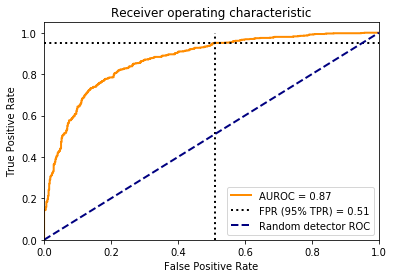

{'fpr_at_95_tpr': 0.5101351351351351, 'detection_error': 0.2795650550047535, 'auroc': 0.8712491936031509, 'aupr_in': 0.8975693210853195, 'aupr_out': 0.8335358153090812}


In [96]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

IDD Val

In [ ]:
if True:
    save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
    extract_idd_mc_softmax(idd_val_dataset, trainer.faster_rcnn, save_file)

/opt/conda/conda-bld/pytorch_1565272271120/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [ ]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = -mcu.predicted_entropy(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

## Mutual Information

Kitti Val

In [ ]:
save_file = os.path.join(CHECKPOINT_DIR, "kitti_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))

IDD Val

In [ ]:
save_file = os.path.join(CHECKPOINT_DIR, "idd_cars_detections_val_mc_dropout.hdf5")
X, y = read_mc_scores(save_file)

kitti_val_novelty_scores = mcu.mutual_information(X)
plot_roc(kitti_val_novelty_scores, y)
print(calc_metrics(kitti_val_novelty_scores, y))